# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 8</span>


The variational principle in Quantum Mechanics states that the expectation value of the Hamiltonian over a (good) trial quantum state has the ground state energy $E_0$ as lower bound:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

During this exercise you will variationally optimize the ground state of a single quantum particle in a one dimensional (1D) space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

This 1D quantum model is not analytically solvable and should be attacked by numerical methods. In order to obtain an approximate wave function for the ground state, the Variational Monte Carlo method uses a trial wave function, parametrized by a set of variational parameters. An approximate model for the ground state wave function is the following trial wave function:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

$\Psi_T^{\sigma,\mu}(x)$ depends on <span style="color:red">two variational parameters: $\sigma$ and $\mu$</span>.

### Exercise 08.1

Write a Variational Monte Carlo code for a single quantum particle in 1D which exploits the Metropolis algorithm to sample the square modulus of our trial wave function $|\Psi_T^{\sigma,\mu}(x)|^2$ using an uniform transition probability $T(x_{new}|x_{old})$. By using data blocking, the code should be able to compute the expectation value for the Hamiltonian

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

which can be used to find the parameters that minimize this quantity. Use $\hbar = 1$ and $m=1$.
<span style="color:red">Note that to measure $\langle {\hat H} \rangle_T$ you need the analytical calculation of:</span>
    
$$
\frac{{-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}} \Psi_T^{\sigma,\mu}(x)}{\Psi_T^{\sigma,\mu}(x)}
$$

### Exercise 08.2

To find the parameters $\sigma$ and $\mu$ which minimize $\langle {\hat H} \rangle_T$, extend your Variational Monte Carlo code to face the variational optimization problem via a <span style="color:red">Simulated Annealing (SA) algorithm</span>.

Choose an appropriate starting temperature for your SA algorithm and an appropriate temperature-update-law to make the optimization work.

Compute $\langle {\hat H} \rangle_T$ with enough statistics in order to be able to measure the lowering of $\langle {\hat H} \rangle_T$ once the variational parameters are moved.

- <span style="color:red">Show a picture of $\langle {\hat H} \rangle_T$ (with statistical uncertainties) as a function of the SA steps of the algorithm</span>
- you could also show a picture of the trajectory of the SA algorithm in the variational parameter space as a function of the SA steps
- <span style="color:red">show a picture of the estimation of $\langle {\hat H} \rangle_T$ </span> and its statistical uncertainty as a function of the number of blocks/MC steps <span style="color:red">for the set of parameters which minimize $\langle {\hat H} \rangle_T$</span>
- <span style="color:red">show also a picture **of the sampled** $|\Psi_T(x)|^2$</span> by filling a histogram with the sampled configurations, moreover compare it with the analytic curve of $|\Psi_T(x)|^2$ and with the numerical solution obtained by transforming the Schrodinger equation into a matrix equation (see below the supplementary material).

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import shutil
import random

#funzione esegui main.exe
def esegui_exe(percorso_exe):
    if not os.path.exists(percorso_exe):
        print("errore: il percorso non esiste")
        return 
    if not percorso_exe.endswith(".exe"):
        print("errore: il percorso non finisce con .exe")
        return  
    
    try:
        subprocess.run(percorso_exe)
    except Exception as e:
        print("errore durante tentativo di esecuzione del .exe ", str(e))

#funzione modifica input
def modifica_parametro(file_path, parametro, nuovo_valore):
    #leggi contenuto del file
    with open(file_path, 'r') as file:
        lines = file.readlines()
    #cerca il parametro da modificre
    for i, line in enumerate(lines):
        if parametro in line:
            lines[i] = line.split()[0]+ " " + str(nuovo_valore)+ "\n"
            break
    with open(file_path, 'w') as file:
        file.writelines(lines) 

In [8]:
#### SIMULATED ANNEALING SCRIPT ####
#don't run this code without commenting the x file saving on the main
#setting initial parameters
sigma = 1
mu = 1

sigma_new = 0
mu_new = 0
H = 0
H_err = 0
H_new = 0
delta_mu = 0.1
delta_sigma = 0.1

H_arr = []
H_err_arr = []

sigma_arr = [sigma]
mu_arr = [mu]

modifica_parametro("./input.dat", "MU", mu)
modifica_parametro("./input.dat", "SIGMA", sigma)
esegui_exe("./main.exe")

with open("./Hamiltonian.out", 'r') as file:
    lines = file.readlines()
    H = float(lines[-2].split()[1])
    H_err = float(lines[-2].split()[2])

H_arr.append(H)
H_err_arr.append(H_err)

for beta10 in range(10, 50, 10):
    beta = beta10 / 10.0
    for n in range(0,20):
        flag = True
        while flag:
            sigma_new = sigma + delta_sigma * (random.random()*2-1)
            modifica_parametro("./input.dat", "SIGMA", sigma_new)
            mu_new = mu + delta_mu * (random.random()*2-1)
            modifica_parametro("./input.dat", "MU", mu_new)
            esegui_exe("./main.exe")

            with open("./Hamiltonian.out", 'r') as file:
                lines = file.readlines()
                H_new = float(lines[-2].split()[1])
                H_err = float(lines[-2].split()[2])

            prob = np.exp(-beta*(H_new - H))

            if random.random() < prob:
                sigma = sigma_new
                mu = mu_new
                H = H_new
                flag = False
                H_arr.append(H)
                H_err_arr.append(H_err)
                sigma_arr.append(sigma)
                mu_arr.append(mu)

print("MU = " + str(mu))
print("SIGMA = " + str(sigma))
print("ground state Energy = " + str(H)+ " with an error of "+ str(H_err))

MU = 0.7943217275227541
SIGMA = 0.5079887704131933
ground state Energy = -0.444338 with an error of 0.0115212


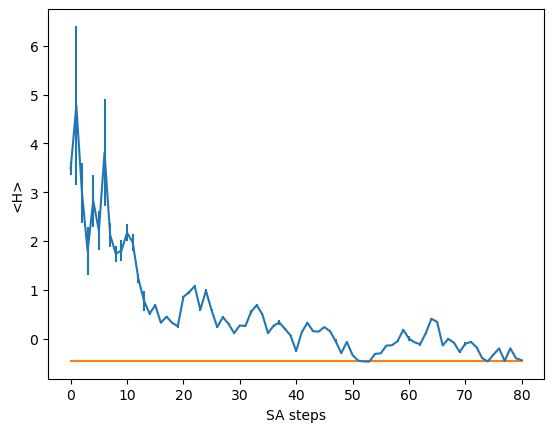

In [10]:
def constant_function(x):
    return -0.46046587969271546

n = np.arange(0,81)
plt.errorbar(n, H_arr, yerr = H_err_arr)
plt.plot(n, np.full(n.shape, constant_function(n)))
plt.xlabel('SA steps')
plt.ylabel('<H>')
plt.show()

Above is shown the average $<H>$ and its error as a function of the number of Simulated Annealing steps. Note that it never goes below the orange line, wich is set to indicate the ground state energy, as it is predicted by the variational principle.

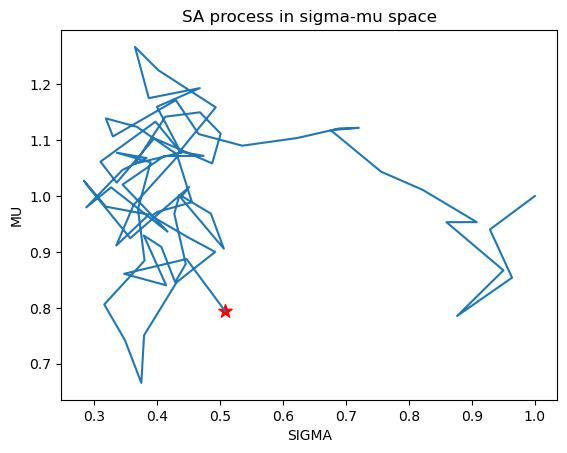

In [18]:
plt.plot(sigma_arr, mu_arr)
plt.xlabel("SIGMA")
plt.ylabel("MU")
plt.title("SA process in sigma-mu space")
plt.scatter(sigma, mu, marker="*", color="red", s=100)
plt.show()

Above is shown the trajectory of the free parameters during the SA. The longer the steps the higher is the temperature set. The red star points to the final choice of parameters.

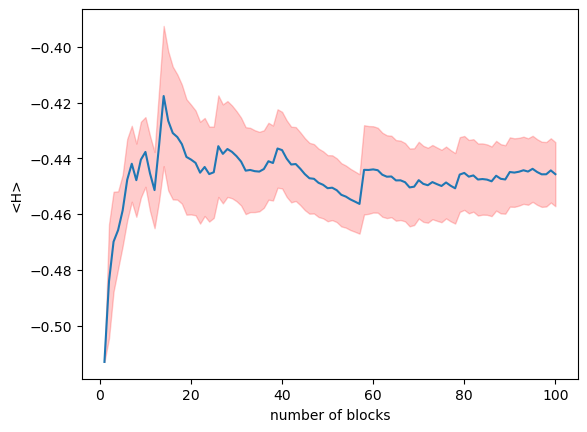

In [19]:
n, H, err = np.loadtxt("hamiltonian.out", usecols=(0,1,2), delimiter= "\t", unpack='true')
plt.plot(n, H)
plt.fill_between(n, H - err, H + err, color='red', alpha=0.2, label='Error')
plt.xlabel('number of blocks')
plt.ylabel('<H>')
plt.show()

Above is shown the graph for the average and error (computed by data blocking) of the hamiltonian for the state with the free parameters fixed at the last iteration of the SA. 

### <span style="color:green">Supplementary material</span>

How can we describe a wave function as a vector? We set up a lattice of discrete points, spaced by a constant distance $dx$, and record the value of the function at each lattice point. In this way the wave function, $\Psi(x)$ become a vector:

$$
\Psi(x) \to \left[ \Psi(x_1), \Psi(x_2), ..., \Psi(x_N) \right] = 
\left[ \Psi_1, \Psi_2, ..., \Psi_N \right]
$$

The time independent Schrodinger equation 

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

can be written in matrix form. But how do we write the second derivative at a particular point? Let's start with the first derivatives:
$$
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) \simeq \frac{\Psi_{i+1}-\Psi_{i}}{dx}\\
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right) \simeq \frac{\Psi_{i}-\Psi_{i-1}}{dx}
$$

Thus, we can discretize the second derivative in the following way:
$$
\frac{\partial^2}{\partial x^2} \Psi(x=x_i) =
\frac{\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) - \frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right)}{dx} =
\frac{\Psi_{i+1}-2\Psi_{i}+\Psi_{i-1}}{dx^2}
$$

We finally obtain:

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

To solve the time independent Schrodinger equation we therefore have to find eigenstates and eigenvalues of the matrix just obtained.

Ground state energy:  -0.46046587969271546
1st excited state energy:  0.09742471331761056
2nd excited state energy:  1.9717331343930202


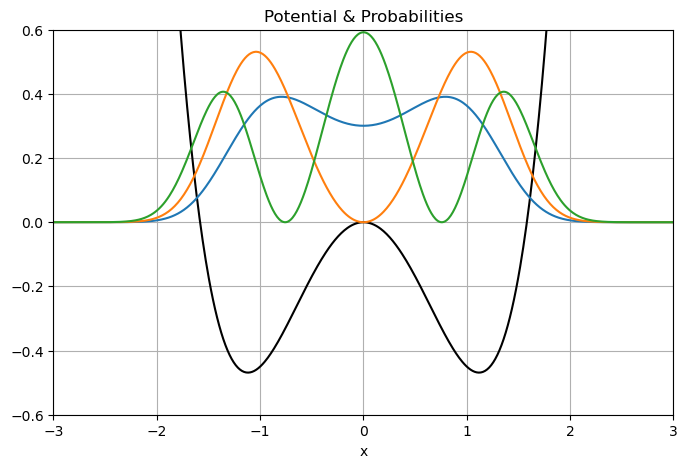

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

# Plot a few things
plt.figure(figsize=(8,5))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(psi[0])**2)
plt.plot(x,(psi[1])**2)
plt.plot(x,(psi[2])**2)
plt.title("Potential & Probabilities")
plt.xlabel("x")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.show()

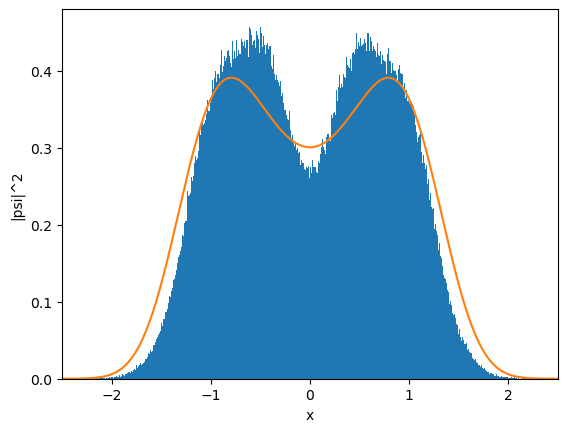

In [25]:
esegui_exe("./main.exe")
x_sam = np.loadtxt("sampled_x.out", usecols = (0), unpack = True)

#plot histogram of x sampled during the last H calculation for final values of MU and Sigma
plt.hist(x_sam, bins = 1000, density=True)
plt.xlabel("x")
plt.ylabel("|psi|^2")

#plot expected ground state probability distribution
plt.plot(x,(psi[0])**2)

plt.xlim(-2.5, 2.5)

plt.show()

Above a graphic comparison of the probability distribution of the state found by SA ($|\psi| ^2$) and of the state predicted analitically. The fit is decent and the parameters lead to an energy middle value close to the ground state energy.